Import použitých knižníc

In [13]:
# Tieto importy treba na final verziu zjednotit
import pandas as pd
import glob, os

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import mplfinance as fplt

from pandas.tseries.offsets import BMonthEnd, BDay



import numpy as np



In [689]:
files = glob.glob('InputData/*.csv')
df = pd.concat([pd.read_csv(fp, parse_dates=True).assign(Title=os.path.basename(fp).split('.')[0]) 
       for fp in files])

df['Date'] = pd.to_datetime(df['Date'])

# Create a new column 'is_last_day' to identify the last day of the month
df['IsLastDayOfMnth'] = df['Date'].dt.is_month_end

# set the index
df.set_index('Date', inplace=True)

df.rename(columns={'Adj Close':'AdjClose'}, inplace=True)

# Use the BMonthEnd offset to find the last business day of each month
LastBusinessDay = df.groupby(pd.Grouper(freq='M')).apply(lambda x: x.index + BMonthEnd())

# Add a boolean column indicating if the date is the last business day
df['LastBusinessDay'] = df.index.isin(LastBusinessDay)

# Calculate daily returns. Calculate from CLOSE price (not form Adj. Close). Create separate column.
df['RDaily'] = df.Close / df.Open - 1

# Sort the DataFrame by a specific column and index
#df = df.sort_values(by='Title', ascending=True).sort_index(ascending=True)

print (df.head())
#print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
#print(df.info())

                 Open       High        Low      Close   AdjClose    Volume  \
Date                                                                          
2018-04-18  47.910000  48.310001  47.840000  48.139999  43.171364  80289500   
2018-04-19  48.259998  48.290001  47.700001  47.860001  42.920261  67581100   
2018-04-20  47.590000  47.619999  47.049999  47.259998  42.382191  80997700   
2018-04-23  47.169998  47.299999  46.779999  46.880001  42.041412  74337500   
2018-04-24  47.259998  47.360001  46.430000  46.660000  41.844120  72196800   

           Title  IsLastDayOfMnth  LastBusinessDay    RDaily  
Date                                                          
2018-04-18   EEM            False            False  0.004801  
2018-04-19   EEM            False            False -0.008288  
2018-04-20   EEM            False            False -0.006934  
2018-04-23   EEM            False            False -0.006148  
2018-04-24   EEM            False            False -0.012696  


In [44]:
DistinctTitles=df['Title'].unique()

SelectTitle=widgets.ToggleButtons(
    options=DistinctTitles,
    description='Title:',
    disabled=False,
    button_style=''
)

def DistinctTitlePlot(SelectTitle):
    fplt.plot(  df[df['Title'] == SelectTitle],
            type='candle',
            style='charles',
            title=SelectTitle,
            ylabel='Price ($)',
            volume=True,
            ylabel_lower='Volume',
            warn_too_much_data=99999999
            )

   
out1 = widgets.interactive_output(DistinctTitlePlot, {'SelectTitle': SelectTitle})

display(SelectTitle)
display(out1)

ToggleButtons(description='Title:', options=('EEM', 'GLD', 'SPY', 'TLT', 'VGK'), value='EEM')

Output()

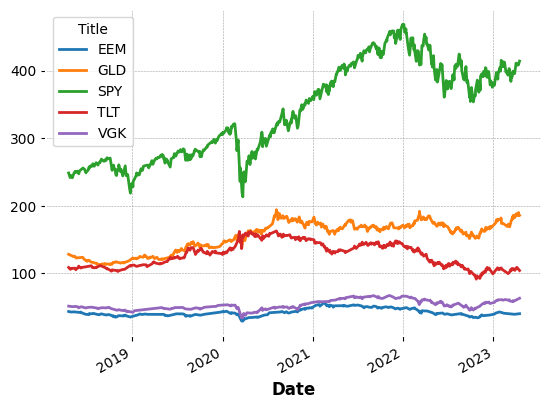

In [70]:
df.pivot(columns="Title", values="AdjClose").plot()

plt.show()

In [99]:
""" # Add separate columns for year, month, and day
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

# Group the DataFrame by 'Title', 'Year', and 'Month'
grouped_df = df.groupby(['Title', 'Year', 'Month'])

# Iterate through each group
for (title, year, month), group in grouped_df:
    # Perform operations """

""" 
#Percent change example
tmp = pd.Series([100, 110, 100, 200])
tmp.pct_change()

df.Close.pct_change() """

' \n#Percent change example\ntmp = pd.Series([100, 110, 100, 200])\ntmp.pct_change()\n\ndf.Close.pct_change() '

In [690]:
# Initialize an empty list to store the values
tmp = []

grouped_df = df.groupby(['Title', df.index.year, df.index.month])

for (title, year, month), group in grouped_df:
    std_value = group['RDaily'].std()
    inv_std_value = 1/group['RDaily'].std()
    tmp.append([title, year, month, std_value, inv_std_value])

# Create a new DataFrame from the collected data
df_mthly = pd.DataFrame(tmp, columns=['Title', 'Year', 'Month', 'StdValue', 'InvStdVal'])

# Print the result DataFrame
print(df_mthly.head())

  Title  Year  Month  StdValue   InvStdVal
0   EEM  2018      4  0.007247  137.994093
1   EEM  2018      5  0.006033  165.758525
2   EEM  2018      6  0.006776  147.579920
3   EEM  2018      7  0.005185  192.865375
4   EEM  2018      8  0.006344  157.627929


# MODEL 1

In [211]:
InitialCapitalValue = 1
PortfolioValAfterFirstRebalancing = 100

In [251]:
# Calculate the actual value of the position for each title

#df['ValueOfPosition'] = 
df.groupby('Title')['RDaily'].apply(lambda x: (1 + x).cumprod())



# Calculate the actual value of the position for each title
new_column = df.groupby('Title')['RDaily'].apply(lambda x: (1 + x).cumprod())

df['Value'] = new_column.reset_index(level=0, drop=True)


# Identify the first day of each month
#month_starts = df.resample('M').max().index
month_starts = df.groupby(pd.Grouper(freq='M')).max().index


# Initialize the weights and portfolio value
weights = None
portfolio_value = 100




month_starts['Date'] = pd.to_datetime(month_starts['Date']).dt.date

df['Date'] = pd.to_datetime(df['Date']).dt.date



Title  Date      
EEM    2018-04-18    1.004801
       2018-04-19    0.996472
       2018-04-20    0.989563
       2018-04-23    0.983479
       2018-04-24    0.970993
                       ...   
VGK    2023-04-11    1.257328
       2023-04-12    1.255112
       2023-04-13    1.260502
       2023-04-14    1.257510
       2023-04-17    1.257510
Name: RDaily, Length: 6290, dtype: float64

In [691]:
df_mthly_pivot = df_mthly.pivot(index=['Year','Month'], columns="Title", values="InvStdVal")
df_mthly_pivot['Sum_InvStdVal'] = df_mthly_pivot['EEM'] + df_mthly_pivot['GLD'] + df_mthly_pivot['SPY'] + df_mthly_pivot['TLT'] + df_mthly_pivot['VGK']

df_mthly_pivot['W_EEM'] = df_mthly_pivot['EEM'] / df_mthly_pivot['Sum_InvStdVal']
df_mthly_pivot['W_GLD'] = df_mthly_pivot['GLD'] / df_mthly_pivot['Sum_InvStdVal']
df_mthly_pivot['W_SPY'] = df_mthly_pivot['SPY'] / df_mthly_pivot['Sum_InvStdVal']
df_mthly_pivot['W_TLT'] = df_mthly_pivot['TLT'] / df_mthly_pivot['Sum_InvStdVal']
df_mthly_pivot['W_VGK'] = df_mthly_pivot['VGK'] / df_mthly_pivot['Sum_InvStdVal']

df_mthly_pivot['W_CHECK_SUM'] = df_mthly_pivot['W_EEM'] + df_mthly_pivot['W_GLD'] + df_mthly_pivot['W_SPY'] + df_mthly_pivot['W_TLT'] + df_mthly_pivot['W_VGK']

df_mthly_pivot.head()

Title              EEM         GLD         SPY         TLT         VGK  \
Year Month                                                               
2018 4      137.994093  366.930724  140.808958  285.519634  364.411648   
     5      165.758525  346.915324  187.129699  265.208375  192.750922   
     6      147.579920  416.209061  213.751118  261.757311  218.517216   
     7      192.865375  313.236880  207.502169  288.566267  276.674672   
     8      157.627929  239.140809  303.478068  368.730563  245.437394   

Title       Sum_InvStdVal     W_EEM     W_GLD     W_SPY     W_TLT     W_VGK  \
Year Month                                                                    
2018 4        1295.665058  0.106504  0.283199  0.108677  0.220365  0.281255   
     5        1157.762845  0.143171  0.299643  0.161630  0.229070  0.166486   
     6        1257.814627  0.117330  0.330899  0.169938  0.208105  0.173728   
     7        1278.845363  0.150812  0.244937  0.162257  0.225646  0.216347   
     8        1314.414763  0.119923  0.181937  0.230885  0.280528  0.186728   

Title       W_CHECK_SUM  
Year Month               
2018 4              1.0  
     5              1.0  
     6              1.0  
     7              1.0  
     8              1.0

In [692]:

#df_mthly_pivot.reset_index().melt(id_vars=['W_CHECK_SUM'])


df_mthly_unpivot = df_mthly_pivot.stack(level=(0)).reset_index()

df_mthly_unpivot = df_mthly_unpivot[df_mthly_unpivot["Title"].isin(["W_EEM", "W_GLD", 'W_SPY', 'W_TLT', 'W_VGK'])].copy()

df_mthly_unpivot.columns.values[-1] = "W"

df_mthly_unpivot['Title'] = df_mthly_unpivot['Title'].str.replace('W_', '')

df_mthly_unpivot.head(5)



,Year,Month,Title,W
6,2018,4,EEM,0.106504
7,2018,4,GLD,0.283199
8,2018,4,SPY,0.108677
9,2018,4,TLT,0.220365
10,2018,4,VGK,0.281255


In [696]:
# v df_mthly_unpivot najskor odstranil 'W_'
# na df leftjoinovat df_mthly_unpivot dla index.year, index.mont a Title

df['Title'] = df['Title'].astype(str)
df_mthly_unpivot['Title'] = df_mthly_unpivot['Title'].astype(str)

df_comp = pd.merge(df.reset_index(), df_mthly_unpivot.reset_index(), how='left', 
                   left_on=[df.reset_index()['Date'].dt.year, df.reset_index()['Date'].dt.month, 'Title'], 
                   right_on=['Year', 'Month', 'Title'])

In [694]:
# Calculate value of position for each day
# df_comp['PositionValue'] = 1  # Assuming starting capital is 1
# df_comp['PositionValue'] *= (1 + df_comp['RDaily']).cumprod()

In [697]:
# Convert the "Date" column to datetime if it's not already
df_comp['Date'] = pd.to_datetime(df_comp['Date'])

# Extract year and month from the "Date" column
df_comp['Year'] = df_comp['Date'].dt.year
df_comp['Month'] = df_comp['Date'].dt.month

# Find the maximum and minimum date for each year and month
min_max_dates = df_comp.groupby(['Year', 'Month'])['Date'].agg([min, max]).reset_index()

# Merge the min and max dates back to the original DataFrame
df_comp = pd.merge(df_comp, min_max_dates, on=['Year', 'Month'], how='left')

df_comp.head()

,Date,Open,High,Low,Close,AdjClose,Volume,Title,IsLastDayOfMnth,LastBusinessDay,RDaily,index,Year,Month,W,min,max
0,2018-04-18,47.910000,48.310001,47.840000,48.139999,43.171364,80289500,EEM,False,False,0.004801,6,2018,4,0.106504,2018-04-18,2018-04-30
1,2018-04-19,48.259998,48.290001,47.700001,47.860001,42.920261,67581100,EEM,False,False,-0.008288,6,2018,4,0.106504,2018-04-18,2018-04-30
2,2018-04-20,47.590000,47.619999,47.049999,47.259998,42.382191,80997700,EEM,False,False,-0.006934,6,2018,4,0.106504,2018-04-18,2018-04-30
3,2018-04-23,47.169998,47.299999,46.779999,46.880001,42.041412,74337500,EEM,False,False,-0.006148,6,2018,4,0.106504,2018-04-18,2018-04-30
4,2018-04-24,47.259998,47.360001,46.430000,46.660000,41.844120,72196800,EEM,False,False,-0.012696,6,2018,4,0.106504,2018-04-18,2018-04-30


In [915]:
# Perform the pivot operation
result = df_comp.pivot(index=['Date', 'Year', 'Month'], columns='Title', values=['RDaily', 'W'])

# Flatten the column names
result.columns = ['{}_{}'.format(col[1], col[0]) for col in result.columns]

# Reset the index
result = result.reset_index()

# Print the result
#print(result)

# Concatenate the 'Date', 'Year', 'Month' columns from the original dataframe with the 'result' dataframe
new_df_comp = pd.concat([df_comp[['Date', 'Year','Month','min','max', ]], result], axis=1)

#new_df_comp.drop(new_df_comp.iloc[:, 0:1],axis = 1, inplace=True)

new_df_comp = new_df_comp[new_df_comp['VGK_RDaily'].notna()]

new_df_comp.head()


,Date,Year,Month,min,max,Date,Year,Month,EEM_RDaily,GLD_RDaily,SPY_RDaily,TLT_RDaily,VGK_RDaily,EEM_W,GLD_W,SPY_W,TLT_W,VGK_W
0,2018-04-18,2018,4,2018-04-18,2018-04-30,2018-04-18,2018.0,4.0,0.004801,-0.003663,-0.001108,-0.008162,0.000664,0.106504,0.283199,0.108677,0.220365,0.281255
1,2018-04-19,2018,4,2018-04-18,2018-04-30,2018-04-19,2018.0,4.0,-0.008288,-0.001643,-0.002818,-0.000837,-0.004307,0.106504,0.283199,0.108677,0.220365,0.281255
2,2018-04-20,2018,4,2018-04-18,2018-04-30,2018-04-20,2018.0,4.0,-0.006934,-0.000474,-0.008184,-0.003617,-0.000835,0.106504,0.283199,0.108677,0.220365,0.281255
3,2018-04-23,2018,4,2018-04-18,2018-04-30,2018-04-23,2018.0,4.0,-0.006148,0.000000,-0.002582,0.001352,0.000669,0.106504,0.283199,0.108677,0.220365,0.281255
4,2018-04-24,2018,4,2018-04-18,2018-04-30,2018-04-24,2018.0,4.0,-0.012696,0.003578,-0.017742,-0.002199,-0.006010,0.106504,0.283199,0.108677,0.220365,0.281255


In [916]:
def remove_dup_columns(frame):
     keep_names = set()
     keep_icols = list()
     for icol, name in enumerate(frame.columns):
          if name not in keep_names:
               keep_names.add(name)
               keep_icols.append(icol)
     return frame.iloc[:, keep_icols]



new_df_comp = remove_dup_columns(new_df_comp)

In [917]:
new_df_comp['Date'].iloc[0] == new_df_comp['min'].iloc[0]

True

In [918]:
new_df_comp.head()

,Date,Year,Month,min,max,EEM_RDaily,GLD_RDaily,SPY_RDaily,TLT_RDaily,VGK_RDaily,EEM_W,GLD_W,SPY_W,TLT_W,VGK_W
0,2018-04-18,2018,4,2018-04-18,2018-04-30,0.004801,-0.003663,-0.001108,-0.008162,0.000664,0.106504,0.283199,0.108677,0.220365,0.281255
1,2018-04-19,2018,4,2018-04-18,2018-04-30,-0.008288,-0.001643,-0.002818,-0.000837,-0.004307,0.106504,0.283199,0.108677,0.220365,0.281255
2,2018-04-20,2018,4,2018-04-18,2018-04-30,-0.006934,-0.000474,-0.008184,-0.003617,-0.000835,0.106504,0.283199,0.108677,0.220365,0.281255
3,2018-04-23,2018,4,2018-04-18,2018-04-30,-0.006148,0.000000,-0.002582,0.001352,0.000669,0.106504,0.283199,0.108677,0.220365,0.281255
4,2018-04-24,2018,4,2018-04-18,2018-04-30,-0.012696,0.003578,-0.017742,-0.002199,-0.006010,0.106504,0.283199,0.108677,0.220365,0.281255


C:\Users\Dell\AppData\Local\Temp\ipykernel_20060\1660418435.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df_comp[i, 'CHECK']  = '*-*-*-*-*-*-*-*-*-*'
C:\Users\Dell\AppData\Local\Temp\ipykernel_20060\1660418435.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df_comp[i, 'CHECK']  = '*-*-*-*-*-*-*-*-*-*'
C:\Users\Dell\AppData\Local\Temp\ipykernel_20060\1660418435.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

<Axes: xlabel='Date', ylabel='EEM_pos_value'>

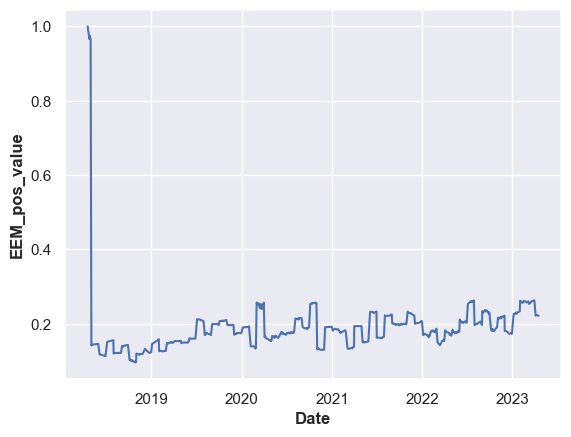

In [913]:
new_df_comp['CHECK'] = 'kkt'

new_df_comp['EEM_pos_value'] = 1
new_df_comp['GLD_pos_value'] = 1
new_df_comp['SPY_pos_value'] = 1
new_df_comp['TLT_pos_value'] = 1
new_df_comp['VGK_pos_value'] = 1

new_df_comp['SUM_all_pos_value'] = 1
#new_df_comp['SUM_all_pos_value'].iloc[0] = 1

initial_capital = 100

cond_year = new_df_comp.loc[4, 'Date'].year == np.sort(new_df_comp['Date'].dt.year.unique())[0] # condition for first year of dataframe
cond_month = new_df_comp.loc[4, 'Date'].month ==  np.sort(new_df_comp.loc[(new_df_comp['Date'].dt.year == np.sort(new_df_comp['Date'].dt.year.unique())[0])]['Date'].dt.month.unique())[1] # second month of first year in dataframe


for i in range(1, len(new_df_comp)):
    if new_df_comp.loc[i, 'Date'] == new_df_comp.loc[i, 'min']: # ak sme na zaciatku mesiaca >>> tuna chceme rebalancovat
        if cond_year == True & cond_month == True: # ak sme na zaciatku druheho mesiaca prveho roku >>>tu rebalancujeme startovaci kapital 100 usd
            new_df_comp.loc[i, 'EEM_pos_value'] = initial_capital*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
            new_df_comp.loc[i, 'GLD_pos_value'] = initial_capital*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
            new_df_comp.loc[i, 'SPY_pos_value'] = initial_capital*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
            new_df_comp.loc[i, 'TLT_pos_value'] = initial_capital*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
            new_df_comp.loc[i, 'VGK_pos_value'] = initial_capital*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])

            new_df_comp.loc[i, 'CHECK']  = 'xxxxxxxxxxxx'

            new_df_comp.loc[i, 'SUM_all_pos_value'] = new_df_comp.loc[i, 'EEM_pos_value']+new_df_comp.loc[i, 'GLD_pos_value']+new_df_comp.loc[i, 'SPY_pos_value']+new_df_comp.loc[i, 'TLT_pos_value']+new_df_comp.loc[i, 'VGK_pos_value']

        else:
            new_df_comp.loc[i, 'EEM_pos_value'] = new_df_comp.loc[i, 'SUM_all_pos_value']*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
            new_df_comp.loc[i, 'GLD_pos_value'] = new_df_comp.loc[i, 'SUM_all_pos_value']*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
            new_df_comp.loc[i, 'SPY_pos_value'] = new_df_comp.loc[i, 'SUM_all_pos_value']*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
            new_df_comp.loc[i, 'TLT_pos_value'] = new_df_comp.loc[i, 'SUM_all_pos_value']*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
            new_df_comp.loc[i, 'VGK_pos_value'] = new_df_comp.loc[i, 'SUM_all_pos_value']*new_df_comp.loc[i, 'EEM_W']*(1+new_df_comp.loc[i, 'EEM_RDaily'])

            new_df_comp.loc[i, 'CHECK']  = 'abababababababab'

            new_df_comp.loc[i, 'SUM_all_pos_value'] = new_df_comp.loc[i, 'EEM_pos_value']+new_df_comp.loc[i, 'GLD_pos_value']+new_df_comp.loc[i, 'SPY_pos_value']+new_df_comp.loc[i, 'TLT_pos_value']+new_df_comp.loc[i, 'VGK_pos_value']
    else:
        new_df_comp.loc[i, 'EEM_pos_value'] = new_df_comp.loc[i-1, 'EEM_pos_value']*(1+new_df_comp.loc[i, 'EEM_RDaily'])
        new_df_comp.loc[i, 'GLD_pos_value'] = new_df_comp.loc[i-1, 'GLD_pos_value']*(1+new_df_comp.loc[i, 'GLD_RDaily'])
        new_df_comp.loc[i, 'SPY_pos_value'] = new_df_comp.loc[i-1, 'SPY_pos_value']*(1+new_df_comp.loc[i, 'SPY_RDaily'])
        new_df_comp.loc[i, 'TLT_pos_value'] = new_df_comp.loc[i-1, 'TLT_pos_value']*(1+new_df_comp.loc[i, 'TLT_RDaily'])
        new_df_comp.loc[i, 'VGK_pos_value'] = new_df_comp.loc[i-1, 'VGK_pos_value']*(1+new_df_comp.loc[i, 'VGK_RDaily'])
        #new_df_comp.loc[i, 'VGK_pos_value'] = 100010000

        new_df_comp.loc[i, 'CHECK']  = '*-*-*-*-*-*-*-*-*-*'

        new_df_comp.loc[i, 'SUM_all_pos_value'] = new_df_comp.loc[i, 'EEM_pos_value']+new_df_comp.loc[i, 'GLD_pos_value']+new_df_comp.loc[i, 'SPY_pos_value']+new_df_comp.loc[i, 'TLT_pos_value']+new_df_comp.loc[i, 'VGK_pos_value']



import seaborn as sns
sns.lineplot(data=new_df_comp, x="Date", y="EEM_pos_value")

In [914]:
new_df_comp.head(30)

,Date,Year,Month,min,max,EEM_RDaily,GLD_RDaily,SPY_RDaily,TLT_RDaily,VGK_RDaily,...,"(1248, CHECK)","(1249, CHECK)","(1250, CHECK)","(1251, CHECK)","(1252, CHECK)","(1253, CHECK)","(1254, CHECK)","(1255, CHECK)","(1256, CHECK)","(1257, CHECK)"
0,2018-04-18,2018,4,2018-04-18,2018-04-30,0.004801,-0.003663,-0.001108,-0.008162,0.000664,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*
1,2018-04-19,2018,4,2018-04-18,2018-04-30,-0.008288,-0.001643,-0.002818,-0.000837,-0.004307,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*
2,2018-04-20,2018,4,2018-04-18,2018-04-30,-0.006934,-0.000474,-0.008184,-0.003617,-0.000835,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*
3,2018-04-23,2018,4,2018-04-18,2018-04-30,-0.006148,0.000000,-0.002582,0.001352,0.000669,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*
4,2018-04-24,2018,4,2018-04-18,2018-04-30,-0.012696,0.003578,-0.017742,-0.002199,-0.006010,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*
5,2018-04-25,2018,4,2018-04-18,2018-04-30,-0.000216,0.001437,0.002739,-0.002129,0.001351,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*
6,2018-04-26,2018,4,2018-04-18,2018-04-30,0.008589,-0.004540,0.005740,0.002124,-0.001005,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*
7,2018-04-27,2018,4,2018-04-18,2018-04-30,0.000423,0.002396,-0.001648,0.003545,0.002519,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*
8,2018-04-30,2018,4,2018-04-18,2018-04-30,-0.010753,0.001447,-0.010290,0.000168,-0.001848,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*
9,2018-05-01,2018,5,2018-05-01,2018-05-31,0.001072,-0.001534,0.004207,-0.003031,-0.003038,...,abababababababab,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*,*-*-*-*-*-*-*-*-*-*


<Axes: xlabel='Date', ylabel='SUM_all_pos_value'>

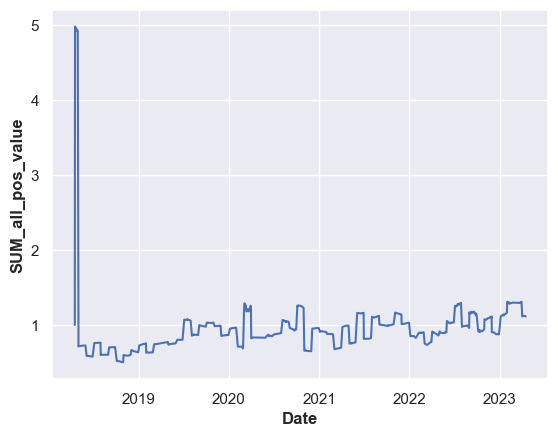

In [888]:
import seaborn as sns
sns.lineplot(data=new_df_comp, x="Date", y="SUM_all_pos_value")

In [798]:
new_df_comp.head()

,Date,Year,Month,min,max,EEM_RDaily,GLD_RDaily,SPY_RDaily,TLT_RDaily,VGK_RDaily,EEM_W,GLD_W,SPY_W,TLT_W,VGK_W,NewColumn,EEM_pos_value
0,2018-04-18,2018,4,2018-04-18,2018-04-30,0.004801,-0.003663,-0.001108,-0.008162,0.000664,0.106504,0.283199,0.108677,0.220365,0.281255,NaN,1
1,2018-04-19,2018,4,2018-04-18,2018-04-30,-0.008288,-0.001643,-0.002818,-0.000837,-0.004307,0.106504,0.283199,0.108677,0.220365,0.281255,20.0,1
2,2018-04-20,2018,4,2018-04-18,2018-04-30,-0.006934,-0.000474,-0.008184,-0.003617,-0.000835,0.106504,0.283199,0.108677,0.220365,0.281255,20.0,1
3,2018-04-23,2018,4,2018-04-18,2018-04-30,-0.006148,0.000000,-0.002582,0.001352,0.000669,0.106504,0.283199,0.108677,0.220365,0.281255,20.0,1
4,2018-04-24,2018,4,2018-04-18,2018-04-30,-0.012696,0.003578,-0.017742,-0.002199,-0.006010,0.106504,0.283199,0.108677,0.220365,0.281255,20.0,1


In [686]:
def perform_operation(row):
    #return row['EEM_RDaily'] * row['GLD_RDaily']  # Modify the operation as needed
    if row['Date'] == row['min']:
        tmp_val = 'a'
    else:
        tmp_val = 'b'
    return(tmp_val)


# Apply the function to each row and create a new column based on the result
new_df_comp['NewColumn'] = new_df_comp.apply(perform_operation, axis=1)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [688]:
new_df_comp['Date'] == new_df_comp['min']

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

In [678]:
new_df_comp.drop(new_df_comp.iloc[:, 6:7],axis = 1, inplace=True)

In [684]:
new_df_comp.head()

,Date,Month,min,max,Date,Month,EEM_RDaily,GLD_RDaily,SPY_RDaily,TLT_RDaily,VGK_RDaily,EEM_W,GLD_W,SPY_W,TLT_W,VGK_W,PositionValue,NewColumn
0,2018-04-18,4,2018-04-18,2018-04-30,2018-04-18,4.0,0.004801,-0.003663,-0.001108,-0.008162,0.000664,0.106504,0.283199,0.108677,0.220365,0.281255,1,-0.000018
1,2018-04-19,4,2018-04-18,2018-04-30,2018-04-19,4.0,-0.008288,-0.001643,-0.002818,-0.000837,-0.004307,0.106504,0.283199,0.108677,0.220365,0.281255,1,0.000014
2,2018-04-20,4,2018-04-18,2018-04-30,2018-04-20,4.0,-0.006934,-0.000474,-0.008184,-0.003617,-0.000835,0.106504,0.283199,0.108677,0.220365,0.281255,1,0.000003
3,2018-04-23,4,2018-04-18,2018-04-30,2018-04-23,4.0,-0.006148,0.000000,-0.002582,0.001352,0.000669,0.106504,0.283199,0.108677,0.220365,0.281255,1,-0.000000
4,2018-04-24,4,2018-04-18,2018-04-30,2018-04-24,4.0,-0.012696,0.003578,-0.017742,-0.002199,-0.006010,0.106504,0.283199,0.108677,0.220365,0.281255,1,-0.000045


<Axes: xlabel='EEM_RDaily', ylabel='Count'>

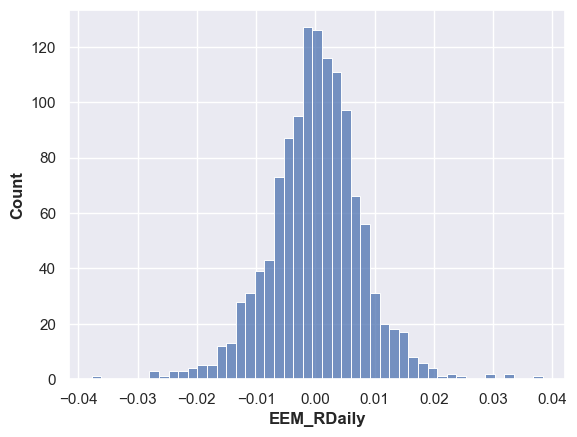

In [682]:
import seaborn as sns

sns.set_theme(style="darkgrid")
sns.histplot(data=new_df_comp, x="EEM_RDaily")

In [ ]:
for i in len(new_df_comp):
    if i % 3 == 0 and i % 5 == 0:
        print('fizzbuzz')
    elif i % 3 == 0:
        print('fizz')
    elif i % 5 == 0:
        print('buzz')
    else:
        print('-')

In [ ]:
# Calculate value of position for each day
new_df_comp['PositionValue'] = 1  # Assuming starting capital is 1
new_df_comp['PositionValue'] *= (1 + df_comp['RDaily']).cumprod()

In [660]:
#df_comp.reset_index(inplace=True)

new_df_comp['PositionValue'] = 1  # Assuming starting capital is 1

for index in new_df_comp.iterrows():
    print(row['TLT_RDaily'] * 1)
    

KeyError: 'TLT_RDaily'

In [636]:
new_df_comp.head()

,Date,Year,Month,min,max,Date,Year,Month,EEM_RDaily,GLD_RDaily,SPY_RDaily,TLT_RDaily,VGK_RDaily,EEM_W,GLD_W,SPY_W,TLT_W,VGK_W,PositionValue
0,2018-04-18,2018,4,2018-04-18,2018-04-30,2018-04-18,2018.0,4.0,0.004801,-0.003663,-0.001108,-0.008162,0.000664,0.106504,0.283199,0.108677,0.220365,0.281255,1
1,2018-04-19,2018,4,2018-04-18,2018-04-30,2018-04-19,2018.0,4.0,-0.008288,-0.001643,-0.002818,-0.000837,-0.004307,0.106504,0.283199,0.108677,0.220365,0.281255,1
2,2018-04-20,2018,4,2018-04-18,2018-04-30,2018-04-20,2018.0,4.0,-0.006934,-0.000474,-0.008184,-0.003617,-0.000835,0.106504,0.283199,0.108677,0.220365,0.281255,1
3,2018-04-23,2018,4,2018-04-18,2018-04-30,2018-04-23,2018.0,4.0,-0.006148,0.000000,-0.002582,0.001352,0.000669,0.106504,0.283199,0.108677,0.220365,0.281255,1
4,2018-04-24,2018,4,2018-04-18,2018-04-30,2018-04-24,2018.0,4.0,-0.012696,0.003578,-0.017742,-0.002199,-0.006010,0.106504,0.283199,0.108677,0.220365,0.281255,1


In [534]:
# Identify the start of each month
start_of_month = df_comp[df_comp['IsMaxDateOfMonth']]

# Perform rebalancing at the start of each month
for i in range(1, len(start_of_month)):
    # Get the start and end dates for rebalancing
    start_date = start_of_month.iloc[i - 1]['Date']
    end_date = start_of_month.iloc[i]['Date']

    # Calculate the weights for rebalancing
    weights = start_of_month.iloc[i]['W']

    # Apply rebalancing based on the weights
    df_comp.loc[(df_comp['Date'] >= start_date) & (df_comp['Date'] < end_date), 'PositionValue'] = df_comp.loc[(df_comp['Date'] >= start_date) & (df_comp['Date'] < end_date), 'PositionValue'] * weights

# Print the updated DataFrame with position values
print(df_comp[['Date', 'Title', 'PositionValue']])

           Date Title  PositionValue
0    2018-04-18   EEM       1.004801
1    2018-04-19   EEM       0.996472
2    2018-04-20   EEM       0.989563
3    2018-04-23   EEM       0.983479
4    2018-04-24   EEM       0.970993
...         ...   ...            ...
6285 2023-04-11   VGK       0.000401
6286 2023-04-12   VGK       0.000401
6287 2023-04-13   VGK       0.000402
6288 2023-04-14   VGK       0.000401
6289 2023-04-17   VGK       1.443755

[6290 rows x 3 columns]


In [ ]:
# Identify the start of each month
start_of_month = df_comp[df_comp['IsMaxDateOfMonth']]

# Perform rebalancing at the start of each month
for i in range(1, len(start_of_month)):
    # Get the start and end dates for rebalancing
    start_date = start_of_month.iloc[i - 1]['Date']
    end_date = start_of_month.iloc[i]['Date']

    # Calculate the weights for rebalancing
    if i == 1:
        # Initial rebalancing with 100 USD
        weights = 100 / df_comp.loc[df_comp['Date'] == start_date, 'PositionValue'].values[0]
    else:
        weights = start_of_month.iloc[i]['W']

    # Apply rebalancing based on the weights
    df_comp.loc[(df_comp['Date'] >= start_date) & (df_comp['Date'] < end_date), 'PositionValue'] = df_comp.loc[(df_comp['Date'] >= start_date) & (df_comp['Date'] < end_date), 'PositionValue'] * weights

# Print the updated DataFrame with position values
print(df_comp[['Date', 'Title', 'PositionValue']])